# Mounting google drive

In order to make it easy to read data from Google Drive, it can be mounted as a "local" unity. This encapsulates the connection to Google API and reduce the amount of coding that would be needed when interacting with Google API

In [1]:
# First check if running on Google Colab
try:
    from google.colab import drive

    # Install required packages
    ! pip install pandarallel
    ! pip install opencv-python

    # Mount Drive
    drive.mount("/content/gdrive", force_remount=True)

    IN_COLAB = True
    file_placement = "/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data"
except:
    IN_COLAB = False

    # Install required packages
    ! pip install opencv-python

    import os
    file_placement = os.path.join(os.getcwd(), "..", "data")
print("running in colab?", IN_COLAB, "\ndata files:", file_placement)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.6 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=e6b6ffd2137cee9497ec828c04cd68e1254a2c8d39b8a9e8959b5f08f52739be
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Mounted at /content/gdrive
running in colab? True 
data files: /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data


# Reading data

The base folder containing the dataset is then read recursivelly. Since labels information are available in the placement (folders), one doesn't need to load the images itself for the initial analysis

In [ ]:
import pathlib

dataset = list(pathlib.Path(file_placement).rglob("*"))
dataset[0:5]

[PosixPath('/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data/Test'),
 PosixPath('/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data/Train'),
 PosixPath('/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data/Test/freshapples'),
 PosixPath('/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data/Test/rottenapples'),
 PosixPath('/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data/Test/freshbanana')]

The files are then converted into a Pandas DataFrame and labels are parsed out in the form of the columns, being:
* **set**: the set to which the image is part of (test or train)
* **label**: the original concatenated label (freshness + type)
* **file_name**: the name of the file containing the image

In [ ]:
import pandas as pd
dataset_df = pd.DataFrame(dataset)
dataset_df["path"] = dataset_df[0].astype(str)
i = dataset_df.columns.get_loc(0)
dataset_split = dataset_df["path"].str.split('/',expand=True)
dataset_df = pd.concat([dataset_df.iloc[:, i+1:], dataset_split], axis=1)
if IN_COLAB:
    dataset_df = dataset_df[["path", 7, 8, 9]]
    dataset_df = dataset_df[dataset_df[9].notnull()]
    dataset_df.rename(columns={7: "set", 8: "label", 9: "file_name"}, inplace=True)
else:
    dataset_df = dataset_df[["path", 11, 12, 13]]
    dataset_df = dataset_df[dataset_df[13].notnull()]
    dataset_df.rename(columns={11: "set", 12: "label", 13: "file_name"}, inplace=True)
dataset_df.head()

,path,set,label,file_name
16,/content/gdrive/MyDrive/08 CS670 Artificial In...,Test,freshapples,Screen Shot 2018-06-08 at 5.09.31 PM.png
17,/content/gdrive/MyDrive/08 CS670 Artificial In...,Test,freshapples,Screen Shot 2018-06-08 at 5.15.09 PM.png
18,/content/gdrive/MyDrive/08 CS670 Artificial In...,Test,freshapples,Screen Shot 2018-06-08 at 5.09.17 PM.png
19,/content/gdrive/MyDrive/08 CS670 Artificial In...,Test,freshapples,Screen Shot 2018-06-08 at 5.03.40 PM.png
20,/content/gdrive/MyDrive/08 CS670 Artificial In...,Test,freshapples,Screen Shot 2018-06-08 at 5.04.24 PM.png


# Data Analysis & Exploration

Let's check the number of images of the dataset

In [ ]:
dataset_df["file_name"].count()

30366

Let's now plot it breaking it by the original set (train or test) to which they belong

<ipython-input-6-f6497c71e29f>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


[Text(0, 0, '23619 (78%)'), Text(0, 0, '6747 (22%)')]

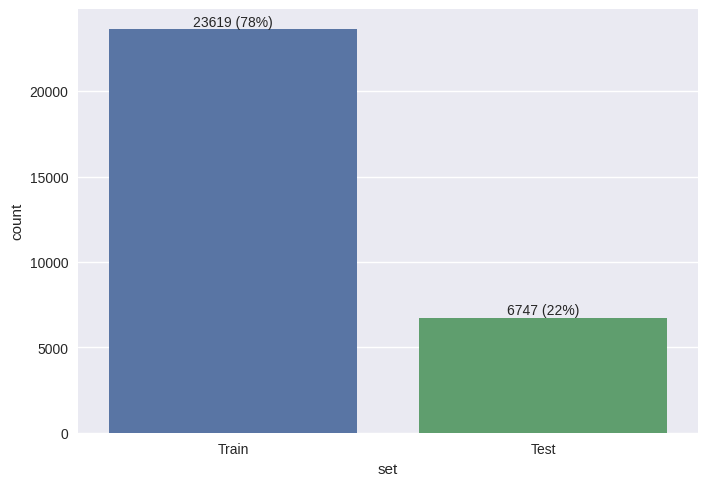

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

ax = sns.countplot(x = dataset_df["set"], order=dataset_df["set"].value_counts(ascending=False).index)
abs_values = dataset_df["set"].value_counts(ascending=False)
rel_values = dataset_df["set"].value_counts(ascending=False, normalize=True).values * 100.00
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=labels)

Now, let's take a look on the distribution per type

[Text(0, 0, '7451 (25%)'),
 Text(0, 0, '7201 (24%)'),
 Text(0, 0, '4291 (14%)'),
 Text(0, 0, '3852 (13%)'),
 Text(0, 0, '1978 (7%)'),
 Text(0, 0, '1891 (6%)'),
 Text(0, 0, '1567 (5%)'),
 Text(0, 0, '1451 (5%)'),
 Text(0, 0, '684 (2%)')]

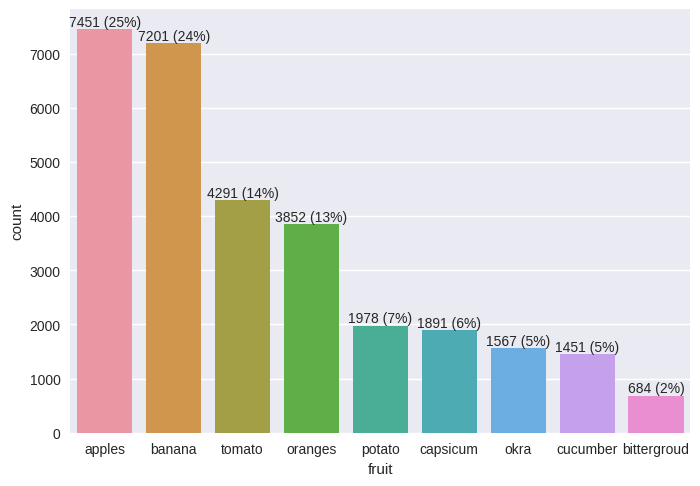

In [ ]:
dataset_df["fruit"] = dataset_df["label"].str.replace("fresh", "").str.replace("rotten", "")
dataset_df["fruit"] = dataset_df["fruit"].map(lambda x : 'tomato' if x == 'tamto' else x)
dataset_df["fruit"] = dataset_df["fruit"].map(lambda x : 'potato' if x == 'patato' else x)
dataset_df["fruit"] = dataset_df["fruit"].map(lambda x : 'bittergroud' if x == 'bittergourd' else x)
ax = sns.countplot(x = dataset_df["fruit"], order=dataset_df["fruit"].value_counts(ascending=False).index)
abs_values = dataset_df["fruit"].value_counts(ascending=False)
rel_values = dataset_df["fruit"].value_counts(ascending=False, normalize=True).values * 100.00
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=labels)

As we decided to work with bananas in this experiment, we filter the dataset to keep only bananas and check how balanced are the types per freshness

<ipython-input-8-987b2c5477ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df["fresh"] = dataset_df["label"].str.contains("fresh")


[Text(0, 0, '3841 (53%)'), Text(0, 0, '3360 (47%)')]

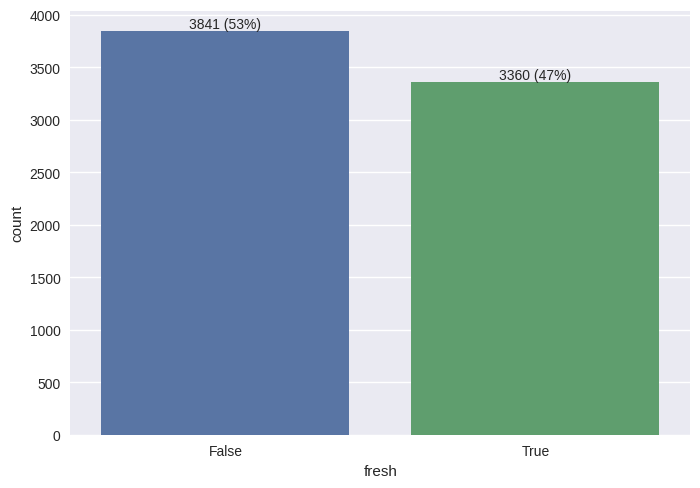

In [ ]:
dataset_df = dataset_df[dataset_df["fruit"] == "banana"]
dataset_df["fresh"] = dataset_df["label"].str.contains("fresh")
ax = sns.countplot(x = dataset_df["fresh"], order=dataset_df["fresh"].value_counts(ascending=False).index)
abs_values = dataset_df["fresh"].value_counts(ascending=False)
rel_values = dataset_df["fresh"].value_counts(ascending=False, normalize=True).values * 100.00
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=labels)

Now, let's drill a little bit down and load the image definitions (we need to first open them)

In [ ]:
import imageio.v3 as iio
from pandarallel import pandarallel
import os

def load_image_info(path):
    image = iio.imread(path)
    return image.shape

max_cpu_cores = os.cpu_count()

pandarallel.initialize(progress_bar = True, nb_workers = max_cpu_cores)
dataset_df["image_info"] = dataset_df["path"].parallel_apply(lambda x: load_image_info(x))

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Let's extract the definitions (height, width, channel) and then get some statistics about it

In [ ]:
dataset_df["height"] = dataset_df["image_info"].str[0]
dataset_df["width"] = dataset_df["image_info"].str[1]
dataset_df["channels"] = dataset_df["image_info"].str[2]
dataset_df["pixels_per_channel"] = dataset_df["height"] * dataset_df["width"]
dataset_df["total_of_features"] = dataset_df["pixels_per_channel"] * dataset_df["channels"]
dataset_df["total_of_features_rgb"] = dataset_df["pixels_per_channel"] * 3

Now, we extract the statistics about width and height

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
dataset_df[["height", "width"]].describe()

,height,width
count,7201.00,7201.00
mean,378.05,511.81
std,63.40,133.45
min,128.00,174.00
25%,344.00,424.00
50%,388.00,532.00
75%,420.00,608.00
max,518.00,862.00


<Axes: >

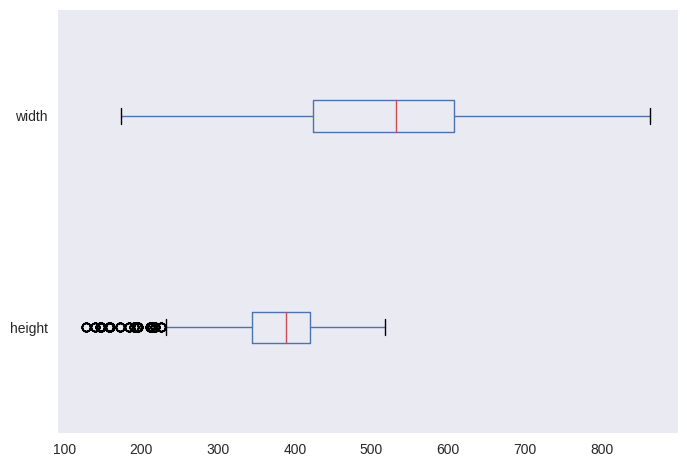

In [ ]:
dataset_df[["height", "width"]].boxplot(grid=False, vert=False)

Checking the number of images per channel

[Text(0, 0, '6199 (86%)'), Text(0, 0, '1002 (14%)')]

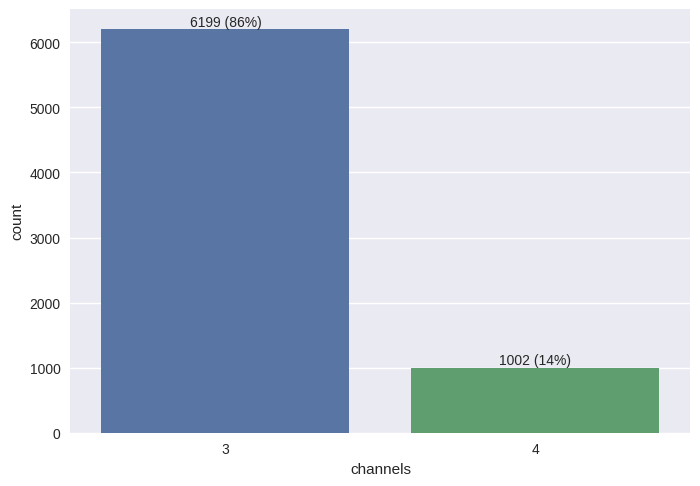

In [ ]:
ax = sns.countplot(x = dataset_df["channels"], order=dataset_df["channels"].value_counts(ascending=False).index)
abs_values = dataset_df["channels"].value_counts(ascending=False)
rel_values = dataset_df["channels"].value_counts(ascending=False, normalize=True).values * 100.00
labels = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=labels)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
display(dataset_df[["total_of_features", "total_of_features_rgb"]].describe())

,total_of_features,total_of_features_rgb
count,7201.00,7201.00
mean,619904.59,592322.84
std,226894.73,205453.17
min,76212.00,76212.00
25%,461820.00,449880.00
50%,633936.00,613080.00
75%,766080.00,738360.00
max,1533280.00,1149960.00


<Axes: >

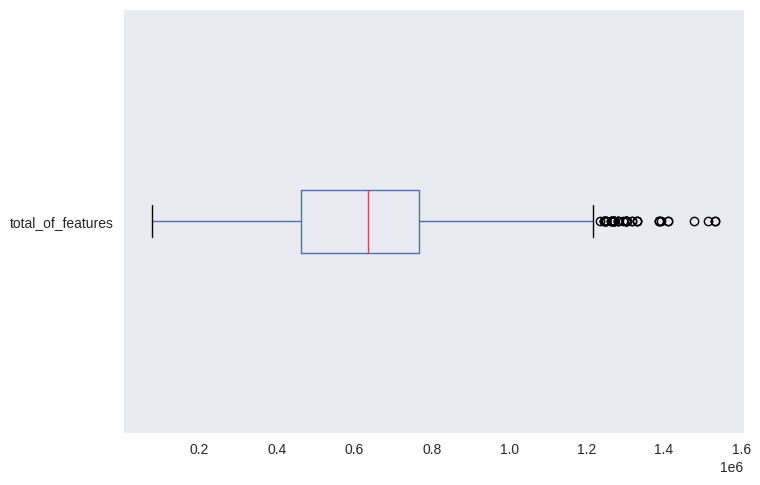

In [ ]:
dataset_df[["total_of_features"]].boxplot(grid=False, vert=False)

<Axes: >

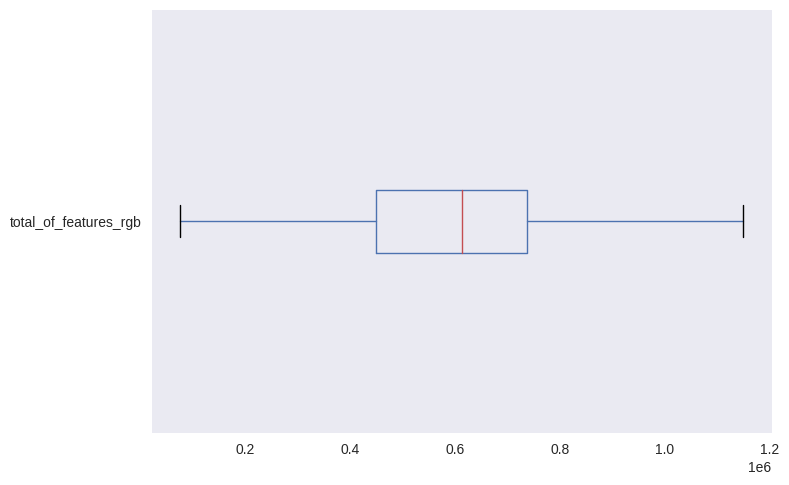

In [ ]:
dataset_df[["total_of_features_rgb"]].boxplot(grid=False, vert=False)

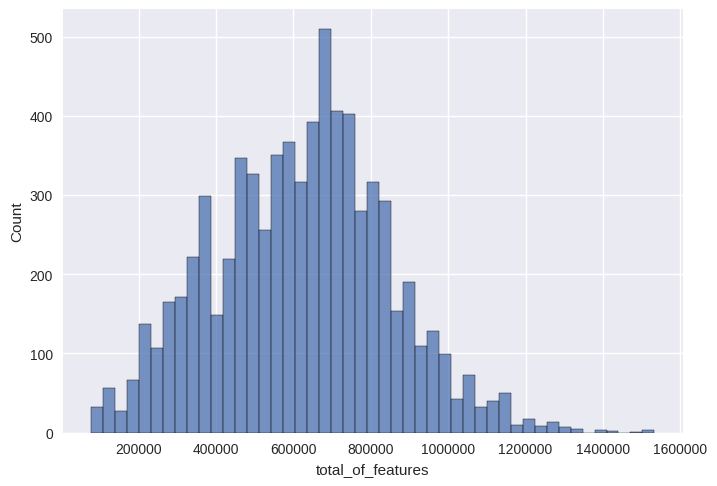

In [ ]:
sns.histplot(data=dataset_df, x="total_of_features")
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Visualizing the images

Let's take a look on some "random" images along with their histograms

Text(0, 0.5, 'Pixel count')

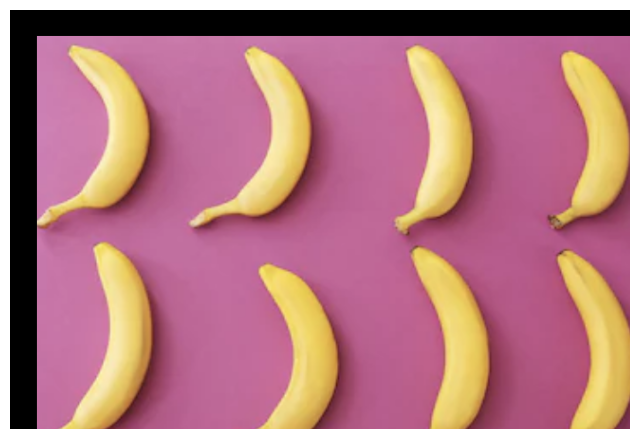

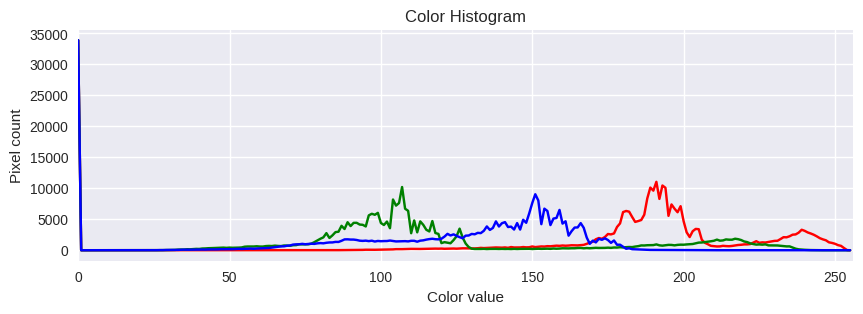

In [ ]:
import numpy as np
import cv2

sample_max_width = (dataset_df[dataset_df["fresh"] == True]).sample(n=1)
image_path = sample_max_width.iloc[0]["path"]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
plt.imshow(image)

plt.axis("off")

colors = ("red", "green", "blue")
plt.figure(figsize=(10,3))
plt.xlim([0, 256])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        image[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color)

blue_color = cv2.calcHist([image], [0], None, [256], [0, 256])
red_color = cv2.calcHist([image], [1], None, [256], [0, 256])
green_color = cv2.calcHist([image], [2], None, [256], [0, 256])

plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")



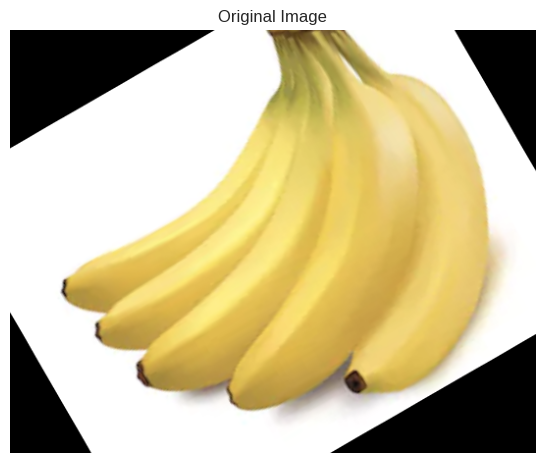

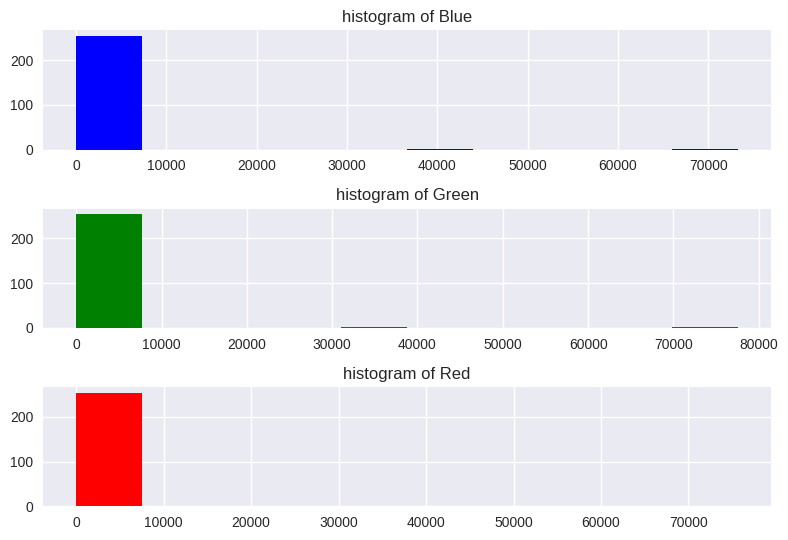

In [ ]:
sample_max_width = (dataset_df[dataset_df["fresh"] == True]).sample(n=1)
image_path = sample_max_width.iloc[0]["path"]

# import necessary packages
import cv2
import matplotlib.pyplot as plt

# load image
imageObj = cv2.imread(image_path)
# to avoid grid lines
plt.axis("off")
plt.title("Original Image")
plt.imshow(cv2.cvtColor(imageObj, cv2.COLOR_BGR2RGB))
plt.show()

# Get RGB data from image
blue_color = cv2.calcHist([imageObj], [0], None, [256], [0, 256])
red_color = cv2.calcHist([imageObj], [1], None, [256], [0, 256])
green_color = cv2.calcHist([imageObj], [2], None, [256], [0, 256])

# Separate Histograms for each color
plt.subplot(3, 1, 1)
plt.title("histogram of Blue")
plt.hist(blue_color, color="blue")

plt.subplot(3, 1, 2)
plt.title("histogram of Green")
plt.hist(green_color, color="green")

plt.subplot(3, 1, 3)
plt.title("histogram of Red")
plt.hist(red_color, color="red")

# for clear view
plt.tight_layout()
plt.show()

# Subsets generation

We then split the dataset into the subset we use train/test set. We will be saving 10% of the total of images for validation

In [ ]:
from sklearn.model_selection import train_test_split

train_and_test, validation = train_test_split(dataset_df, test_size=0.1)

In [ ]:
import os

if IN_COLAB:
    base_folder = os.path.join(file_placement, "..", "..", "Publishing")
else:
    base_folder = os.path.join(file_placement, "..")
validation.to_excel(os.path.join(base_folder, "validation_set.xlsx"), index=False)
train_and_test.to_excel(os.path.join(base_folder, "train_and_test_set.xlsx"), index=False)